<a href="https://colab.research.google.com/github/digwit678/Can-Language-Models-Follow-Discussions/blob/main/sw7_40_most_distinct_discussions_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utility Functions (often used)

In [ ]:
#!pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.0 MB/s eta 0:00:00


In [1]:
base_path_gdrive = "/content/drive/MyDrive/Can Language Models Follow Discussions?/"

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#import igraph as ig
import yaml
import os
import re
from random import seed
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
seed(42)

In [59]:
def load(path_end, file_type="csv"):
  """
  - path_end: provide number + file name
  - file_type: "pkl" for pickle or "" for csv

  """
  base_path_gdrive = r"/content/drive/MyDrive/Can Language Models Follow Discussions?/"
  path = base_path_gdrive + path_end + "." + file_type
  if file_type == "pkl":
    with open (path , 'rb') as f:
        file_out =  pickle.load(f)
  else:
        file_out = pd.read_csv(path)
  print(path, "loaded.")
  return file_out

In [9]:
def save(df, name, probing_task_nr, input_type = "df", output_type = "csv"):
  base_path_gdrive= "/content/drive/MyDrive/Can Language Models Follow Discussions?/"
  full_file_path = base_path_gdrive + f"{probing_task_nr}/{name}.{output_type}"
  if input_type == "df":
    if output_type == "csv":
          df.to_csv(full_file_path)
          print(f"{name}.{output_type} saved to {base_path_gdrive}{probing_task_nr}/")
    if output_type == "pkl":
          df.to_pickle(full_file_path)
  if input_type == "dc":
    if output_type == "pkl":
        with open(full_file_path, 'wb') as f:
          pickle.dump(full_file_path, f)
  print(f'File saved as {full_file_path}')

In [ ]:
def save_dataframe_to_drive(probing_example_nr, df, file_type='e', task_name='task'):
    # Set the base path
    base_path = f"/content/drive/MyDrive/Can Language Models Follow Discussions?/{probing_example_nr}/final probing files/"

    # Create the filename
    filename = f"{probing_example_nr}_{task_name}_data"

    # Full file path
    if file_type == 'p':
        full_file_path = f"{base_path}{filename}.pkl"
        df.to_pickle(full_file_path)
    else:
        full_file_path = f"{base_path}{filename}.xlsx"
        df.to_excel(full_file_path, index=False)

    print(f"File saved at {full_file_path}")

# Example usage:
# save_dataframe_to_drive(1, df, file_type='e', task_name='my_task')


In [ ]:
def print_first_n_entries(dictionary, n, max_inner_items=5):
    """
    Print the first 'n' entries of a nested dictionary, showing only the first 'max_inner_items' key-value pairs of the inner dictionary at each depth level.

    Args:
        dictionary (dict): The nested dictionary to print.
        n (int): The number of entries to print.
        max_inner_items (int): The maximum number of key-value pairs to print from the inner dictionary at each depth level.

    Returns:
        None
    """
    def print_nested_dict(d, depth):
        if depth >= max_depth:
            return

        for key, value in d.items():
            if len(entries) >= n:
                return

            entries.append((key, value))
            print(f"Entry {len(entries)}:")
            print(f"Key: {key}")
            print("Value:")

            if isinstance(value, dict):
                sub_dict = {k: value[k] for k in list(value)[:max_inner_items]}
                print_nested_dict(sub_dict, depth + 1)
            else:
                print(f"  {value}\n")

    max_depth = max_inner_items
    entries = []

    print_nested_dict(dictionary, 0)



In [10]:
from urllib.parse import urlparse
def preprocess_text_with_stopwords(text, stop_words):
    """
    Removes stop words, punctuation, URLs, and converts to lowercase.
    """
    # Extract meaningful parts from URLs (leave away Scheme, Subdomain, Second-level Domain and Top-level Domain)
    text = re.sub(r'\[([^\]]+)]\((https?://[^\s]+)\)',
                  lambda x: ' '.join(urlparse(x.group(2)).path.strip('/').split('/')[-1].split('.')[:-1]),
                  text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize and remove stop words
    text = ' '.join([word for word in word_tokenize(text) if word.isalnum() and word not in stop_words])

    return text


"""
v1 used for BOW, Doc2Vec
def preprocess_text_with_stopwords(text, stop_words):

    Removes stop words, punctuation, and converts to lowercase.

    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'[^\w\s]', '', text)
    return text
    """

"""
v1 used for BOW, Doc2Vec

# List of common stop words in English
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
              "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
              "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was",
              "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and",
              "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between",
              "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off",
              "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any",
              "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
              "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

"""

'\nv1 used for BOW, Doc2Vec\n\n# List of common stop words in English\nstop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",\n              "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",\n              "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was",\n              "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and",\n              "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between",\n              "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off",\n              "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any",\n              

In [ ]:
node_df = load("2/node_attributes_v4")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
node_df.head()

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized Stance Score
0,0,0,333.000,0,0,NaN,333.0,Anonymous currency discussions,Anonymous currency discussions,[333.167],[0],0.000000
1,1,0,333.167,1,0,333.000,333.0,Anonymous currency discussions,"Cryptocurrencies, such as Bitcoin and others, ...","[333.338, 333.168, 333.644, 333.69, 333.794, 3...","[-1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1]",0.454545
2,2,0,333.338,2,0,333.167,333.0,Anonymous currency discussions,Cryptocurrency mining is a waste of resources.,"[333.339, 333.34, 333.355, 333.694, 333.824, 3...","[1, -1, 1, -1, -1, -1, 1]",-0.142857
3,3,0,333.168,2,1,333.167,333.0,Anonymous currency discussions,Cryptocurrencies and the technologies built on...,"[333.891, 333.894]","[1, 1]",1.000000
4,4,0,333.644,2,2,333.167,333.0,Anonymous currency discussions,A cryptocurrency is harder to counterfeit than...,"[333.646, 333.84, 333.697]","[-1, 1, 1]",0.333333


In [ ]:
# for diagrams / displaying
node_df['Shortened_Base_Claim_Text'] = node_df['Base_Claim_Text'].str.slice(0, 50) + "..."


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Determining the 30 - 200 Largest Discussions

In [28]:
# Counting the number of claims per discussion
discussion_claim_counts = node_df[['Base_Claim_ID','Base_Claim_Text']].value_counts().reset_index()
discussion_claim_counts.columns = ['Base_Claim_ID','Base_Claim_Text', 'Number_of_Claims']

In [33]:
# Assuming top_200_discussions is your DataFrame
discussion_claim_counts_unique = discussion_claim_counts.drop_duplicates(subset=['Base_Claim_Text'])

In [34]:
# Selecting top 200 discussions based on the number of claims
top_200_discussions = discussion_claim_counts_unique.nlargest(200, 'Number_of_Claims')

In [35]:
discussion_claim_counts_unique

,Base_Claim_ID,Base_Claim_Text,Number_of_Claims
0,3371.0,What [religion](https://en.wikipedia.org/wiki/...,1298
1,53584.1,The distinction between [Act and Potency](http...,1263
3,29870.1,"Because of the existence of evil, there cannot...",1091
4,2629.1,[God](https://en.wikipedia.org/wiki/Classical_...,1005
8,8708.1,The UK should remain in the EU if a hard Brexi...,826
...,...,...,...
7402,25575.1,Ignroe. Going to delete this,1
7403,25574.2,"No contracts, no activation/cancellation fees,...",1
7404,14421.2,The Petrol Dollar is VaporWare. Once it is all...,1
7405,45242.5,Lincoln only freed the slaves to break the sou...,1


In [16]:
#filtered_discussions_2000 = discussion_claim_counts[discussion_claim_counts['Number_of_Claims'] >= 2000]

observation: no discussions with 2000 or more claims in the dataset


In [ ]:
print("Number of Claims ranges from", min(discussion_claim_counts["Number_of_Claims"]), "-", max(discussion_claim_counts["Number_of_Claims"]))

Number of Claims ranges from 1 - 1298


In [ ]:
discussion_claim_counts.head()

,Base_Claim_ID,Number_of_Claims
0,3371.0,1298
1,53584.1,1263
2,51234.1,1091
3,29870.1,1091
4,2629.1,1005


In [19]:
# Selecting top 40 discussions based on the number of claims
# = discussion_claim_counts.nlargest(40, 'Number_of_Claims')

In [ ]:


# Merging to get the base claim text and generating a bar plot
top_discussions_with_text = pd.merge(top_discussions, node_df[['Base_Claim_ID', 'Base_Claim_Text', 'Shortened_Base_Claim_Text']].drop_duplicates(), on='Base_Claim_ID', how='left')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


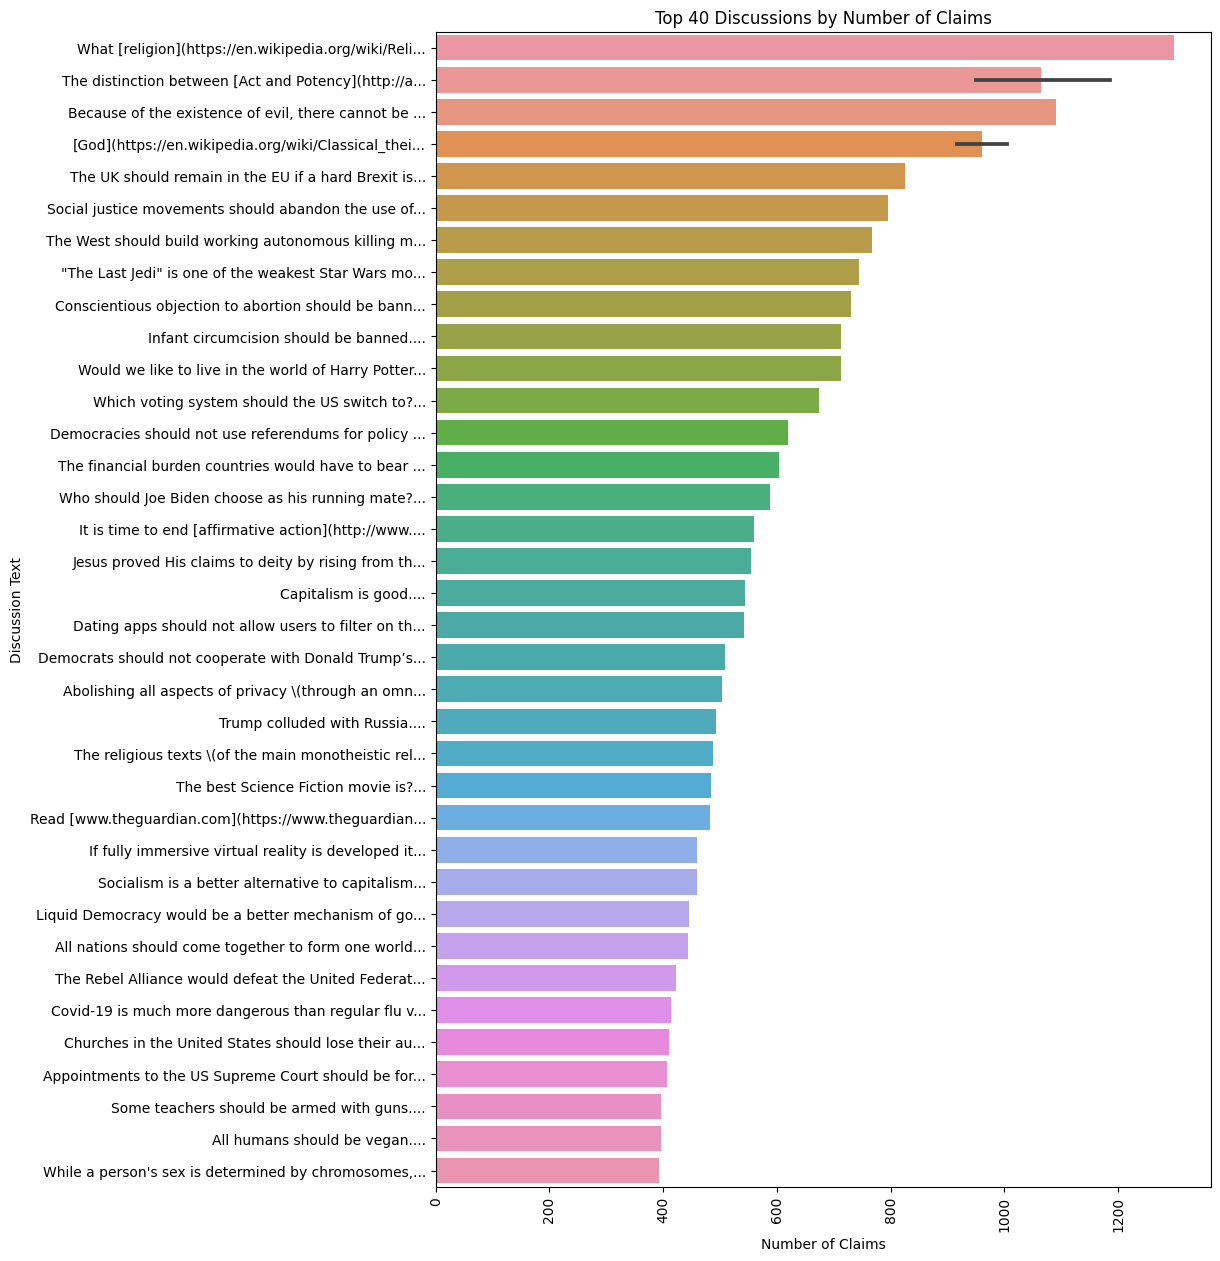

In [ ]:

plt.figure(figsize=(10, 15))
sns.barplot(data=top_discussions_with_text, y='Shortened_Base_Claim_Text', x='Number_of_Claims')
plt.title('Top 40 Discussions by Number of Claims')
plt.xlabel('Number of Claims')
plt.ylabel('Discussion Text')
plt.xticks(rotation=90)
plt.show()

filtering and calculating cosine similarity >= 0.95 for top 40 examples

# Finding Main Topics in the 100 Largest Discussions

TODO : SBERT

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
top_100_discussions_with_text['Processed_Base_Claim_Text'] = top_100_discussions_with_text['Base_Claim_Text'].apply(lambda x: preprocess_text_with_stopwords(x, stop_words))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

In [ ]:
node_df['Processed_Base_Claim_Text'] = node_df['Base_Claim_Text'].apply(lambda x: preprocess_text_with_stopwords(x, stop_words))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Selecting top 100 discussions based on the number of claims
top_100_discussions = discussion_claim_counts.nlargest(100, 'Number_of_Claims')

# Merging to get the base claim text and generating a bar plot
top_100_discussions_with_text = pd.merge(top_100_discussions, node_df[['Base_Claim_ID', 'Base_Claim_Text', 'Processed_Base_Claim_Text']].drop_duplicates(), on='Base_Claim_ID', how='left')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
top_100_discussions_with_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Base_Claim_ID,Number_of_Claims,Base_Claim_Text,Processed_Base_Claim_Text
0,3371.000,1298,What [religion](https://en.wikipedia.org/wiki/...,people follow
1,53584.100,1263,The distinction between [Act and Potency](http...,distinction combined visible fact world entail...
2,51234.100,1091,The distinction between [Act and Potency](http...,distinction combined visible fact world entail...
3,29870.100,1091,"Because of the existence of evil, there cannot...",existence evil monotheistic god traditionally
4,2629.100,1005,[God](https://en.wikipedia.org/wiki/Classical_...,exists
...,...,...,...,...
95,29320.000,286,Who should the Conservative Party choose to be...,conservative party choose next uk prime minister
96,31776.100,283,Creationism should be taught in schools.,creationism taught schools
97,18807.100,279,Feminism empowers both women and men.,feminism empowers women men
98,38531.102,278,The usage of office real estate will continue ...,usage office real estate continue decline past...


In [ ]:
top_100_discussions_with_text['Processed_Base_Claim_Text']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0                                         people follow
1     distinction combined visible fact world entail...
2     distinction combined visible fact world entail...
3         existence evil monotheistic god traditionally
4                                                exists
                            ...                        
95     conservative party choose next uk prime minister
96                           creationism taught schools
97                          feminism empowers women men
98    usage office real estate continue decline past...
99    parents perpetuate myths like santa claus east...
Name: Processed_Base_Claim_Text, Length: 100, dtype: object

## using BERT

In [60]:
node_df = load("1/node_attributes_v5",file_type="pkl")

/content/drive/MyDrive/Can Language Models Follow Discussions?/1/node_attributes_v5.pkl loaded.


In [12]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.3 MB/s eta 0:00:00


In [61]:
node_df.head()

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized_Stance_Score
0,0,0,333.000,0,0,NaN,333.0,Anonymous currency discussions,Anonymous currency discussions,[333.167],[0],0.000000
1,1,0,333.167,1,0,333.000,333.0,Anonymous currency discussions,"Cryptocurrencies, such as Bitcoin and others, ...","[333.338, 333.168, 333.644, 333.69, 333.794, 3...","[-1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1]",0.454545
2,2,0,333.338,2,0,333.167,333.0,Anonymous currency discussions,Cryptocurrency mining is a waste of resources.,"[333.339, 333.34, 333.355, 333.694, 333.824, 3...","[1, -1, 1, -1, -1, -1, 1]",-0.142857
3,3,0,333.168,2,1,333.167,333.0,Anonymous currency discussions,Cryptocurrencies and the technologies built on...,"[333.891, 333.894]","[1, 1]",1.000000
4,4,0,333.644,2,2,333.167,333.0,Anonymous currency discussions,A cryptocurrency is harder to counterfeit than...,"[333.646, 333.84, 333.697]","[-1, 1, 1]",0.333333


In [62]:
# Counting the number of claims per discussion
discussion_claim_counts = node_df[['Base_Claim_ID','Base_Claim_Text']].value_counts().reset_index()
discussion_claim_counts.columns = ['Base_Claim_ID','Base_Claim_Text', 'Number_of_Claims']

In [63]:
# Assuming top_200_discussions is your DataFrame
discussion_claim_counts_unique = discussion_claim_counts.drop_duplicates(subset=['Base_Claim_Text'])

In [64]:
# Selecting top 200 discussions based on the number of claims
top_200_discussions = discussion_claim_counts_unique.nlargest(200, 'Number_of_Claims')

In [65]:
top_200_discussions

,Base_Claim_ID,Base_Claim_Text,Number_of_Claims
0,3371.000,What [religion](https://en.wikipedia.org/wiki/...,1298
1,53584.100,The distinction between [Act and Potency](http...,1263
3,29870.100,"Because of the existence of evil, there cannot...",1091
4,2629.100,[God](https://en.wikipedia.org/wiki/Classical_...,1005
8,8708.100,The UK should remain in the EU if a hard Brexi...,826
...,...,...,...
202,52119.101,The moral argument is good evidence for God.,204
203,5685.100,There is no free will.,204
204,9791.100,Euthanasia should be legalised.,203
205,32197.101,We should not sing problematic Christmas songs.,203


In [53]:
from transformers import BertForMaskedLM, BertTokenizer
import pandas as pd
import torch

# Initialize the BERT model and tokenizer
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize DataFrame to hold the topics of each discussion
discussion_topics_df = pd.DataFrame(columns=['Base_Claim_ID', 'Predicted_Topic'])

# Loop through the DataFrame
for index, row in top_200_discussions.iterrows():
    # Prepare the text
    text = row['Base_Claim_Text']

    # Prepare the masked prompt
    masked_prompt = f"The text is primarily about {tokenizer.mask_token}."

    # Combine text and masked prompt
    combined_text = f"{text} {masked_prompt}"

    # Tokenize and get the output from the model
    inputs = tokenizer(combined_text, return_tensors='pt')
    mask_token_index = torch.where(inputs["input_ids"][0] == tokenizer.mask_token_id)[0]
    output = model(**inputs)

    # Get the token probabilities
    mask_token_logits = output.logits[0, mask_token_index, :]
    mask_token_probs = mask_token_logits.softmax(dim=1)

    # Get the most likely token
    most_likely_token_id = mask_token_probs.argmax().item()
    most_likely_token = tokenizer.convert_ids_to_tokens([most_likely_token_id])[0]

    # Append to DataFrame
    discussion_topics_df = discussion_topics_df.append({'Base_Claim_ID': row['Base_Claim_ID'], 'Predicted_Topic': most_likely_token}, ignore_index=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-53-134a8414ed8c>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  discussion_topics_df = discussion_topics_df.append({'Base_Claim_ID': row['Base_Claim_ID'], 'Predicted_Topic': most_likely_token}, ignore_index

In [55]:
discussion_topics_df.head()

,Base_Claim_ID,Predicted_Topic
0,3371.0,religion
1,53584.1,god
2,29870.1,god
3,2629.1,god
4,8708.1,britain


In [54]:
save(discussion_topics_df,"BERT_200_discussions_with_topics",4,  output_type = "pkl" )

File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/4/BERT_200_discussions_with_topics.pkl


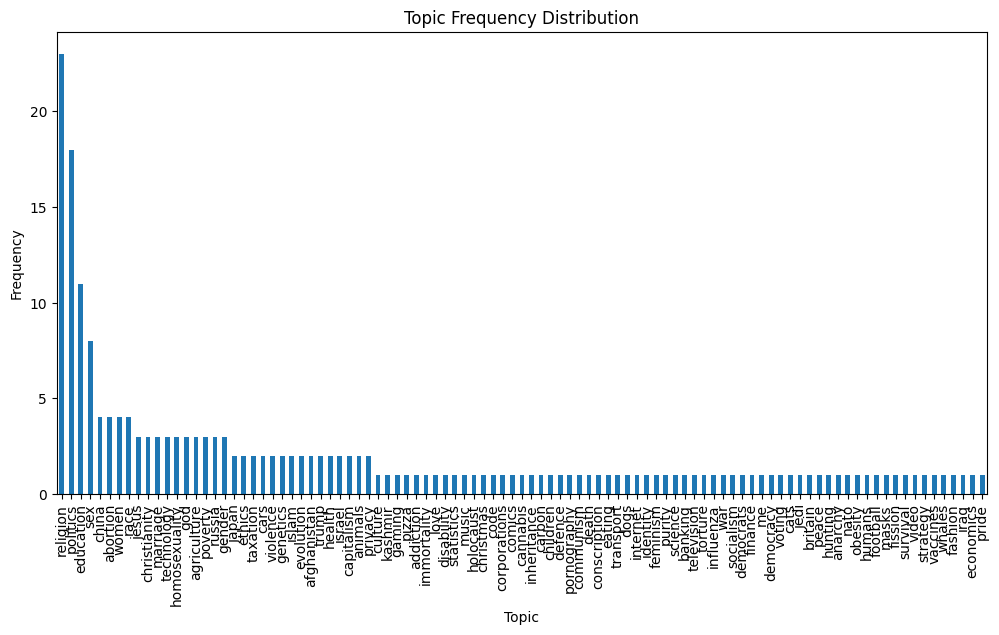

In [79]:
import matplotlib.pyplot as plt

# Plot topic frequency
plt.figure(figsize=(12, 6))
topic_frequency.plot(kind='bar')
plt.title('Topic Frequency Distribution')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.show()


In [51]:
# Merge the original DataFrame with the new DataFrame containing predicted topics
final_df = pd.merge(top_200_discussions, discussion_topics_df, on='Base_Claim_ID', how='left')
final_df.head()

,Base_Claim_ID,Base_Claim_Text,Number_of_Claims,Predicted_Topic
0,3371.0,What [religion](https://en.wikipedia.org/wiki/...,1298,[unk]
1,53584.1,The distinction between [Act and Potency](http...,1263,[unk]
2,29870.1,"Because of the existence of evil, there cannot...",1091,[unk]
3,2629.1,[God](https://en.wikipedia.org/wiki/Classical_...,1005,[unk]
4,8708.1,The UK should remain in the EU if a hard Brexi...,826,[unk]


In [52]:
save(final_df,"BERT_200_discussions_with_topics",4,  output_type = "pkl" )

File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/4/BERT_200_discussions_with_topics.pkl


In [67]:
discussion_topics_df = load("4/BERT_200_discussions_with_topics","pkl")

/content/drive/MyDrive/Can Language Models Follow Discussions?/4/BERT_200_discussions_with_topics.pkl loaded.


In [68]:
# TODO ::: POSTPROCESS THOSE TOPICS TO IDENTIFY THE 40 MOST DIFFERENT ONES + LARGEST ONES (ALWASY TAKE THE LARGEST OUT OF SELECTION as 2ndary criteria)
discussion_topics_df

,Base_Claim_ID,Predicted_Topic
0,3371.000,religion
1,53584.100,god
2,29870.100,god
3,2629.100,god
4,8708.100,britain
...,...,...
195,52119.101,ethics
196,5685.100,religion
197,9791.100,abortion
198,32197.101,christmas


In [78]:
print(sorted_topics.sort_values(ascending=False))

religion     23
politics     18
education    11
sex           8
china         4
             ..
video         1
strategy      1
vaccines      1
whales        1
pride         1
Name: Predicted_Topic, Length: 97, dtype: int64


In [69]:
# Count the frequency of each predicted topic
topic_frequency = discussion_topics_df['Predicted_Topic'].value_counts()

# Sort topics by frequency
sorted_topics = topic_frequency.sort_values(ascending=True)

# Initialize an empty DataFrame to store the top 40 distinct discussions
top_40_distinct_discussions = pd.DataFrame(columns=['Base_Claim_ID', 'Predicted_Topic'])

# Loop through the sorted topics and pick one discussion from each topic
for topic in sorted_topics.index:
    sample_discussion = discussion_topics_df[discussion_topics_df['Predicted_Topic'] == topic].sample(1)
    top_40_distinct_discussions = pd.concat([top_40_distinct_discussions, sample_discussion])

    # Stop when we have 40 discussions
    if len(top_40_distinct_discussions) >= 40:
        break

# Save the top 40 distinct discussions
top_40_distinct_discussions.to_csv('top_40_distinct_discussions.csv', index=False)

top_40_distinct_discussions


,Base_Claim_ID,Predicted_Topic
141,53072.1020,cannabis
29,9394.1000,war
30,34602.1001,influenza
38,10378.1000,torture
42,37719.0000,television
47,47675.1000,banking
23,1257.0000,science
113,29355.1000,purity
92,18807.1000,feminism
177,7018.1000,identity


In [81]:
# Merge the two DataFrames based on 'Base_Claim_ID'
merged_df = pd.merge(discussion_topics_df, top_200_discussions, on='Base_Claim_ID')

# Add a new column for topic frequency
merged_df['Topic_Frequency'] = merged_df['Predicted_Topic'].map(topic_frequency)

# Sort first by topic frequency (ascending) and then by the number of claims (descending)
sorted_df = merged_df.sort_values(by=['Topic_Frequency', 'Number_of_Claims'], ascending=[True, False])
sorted_df

,Base_Claim_ID,Predicted_Topic,Base_Claim_Text,Number_of_Claims,Topic_Frequency
4,8708.100,britain,The UK should remain in the EU if a hard Brexi...,826,1
7,7055.100,jedi,"""The Last Jedi"" is one of the weakest Star War...",745,1
10,2415.100,cats,Would we like to live in the world of Harry Po...,713,1
11,4650.000,voting,Which voting system should the US switch to?,675,1
12,1785.100,democracy,Democracies should not use referendums for pol...,620,1
...,...,...,...,...,...
142,32518.101,religion,Catholic priests should be allowed to marry.,231,23
155,6148.100,religion,Hate speech should be banned.,222,23
164,51562.000,religion,What is the problem with religion?,218,23
184,39518.100,religion,You can be a true follower of a religion witho...,212,23


In [82]:
# Sort the DataFrame first by 'Topic_Frequency' and then by 'Number_of_Claims'
sorted_df = merged_df.sort_values(by=['Topic_Frequency', 'Number_of_Claims'], ascending=[True, False])

# Initialize an empty DataFrame to hold the top 40 discussions
top_40_discussions = pd.DataFrame(columns=sorted_df.columns)

# Initialize an empty set to keep track of topics that have already been selected
selected_topics = set()

# Loop through the sorted DataFrame
for idx, row in sorted_df.iterrows():
    topic = row['Predicted_Topic']

    # Only add the discussion to 'top_40_discussions' if its topic has not been selected yet
    if topic not in selected_topics:
        top_40_discussions = top_40_discussions.append(row)
        selected_topics.add(topic)

    # Break the loop if we've already found the top 40 discussions
    if len(top_40_discussions) >= 40:
        break

# Save the DataFrame
top_40_discussions.to_csv('top_40_discussions.csv', index=False)

top_40_discussions


<ipython-input-82-ed967a87f743>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_40_discussions = top_40_discussions.append(row)
<ipython-input-82-ed967a87f743>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_40_discussions = top_40_discussions.append(row)
<ipython-input-82-ed967a87f743>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_40_discussions = top_40_discussions.append(row)
<ipython-input-82-ed967a87f743>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_40_discussions = top_40_discussions.append(row)
<ipython-input-82-ed967a87f743>:16: FutureWarning: The frame.append method is deprecated and will be removed

,Base_Claim_ID,Predicted_Topic,Base_Claim_Text,Number_of_Claims,Topic_Frequency
4,8708.1000,britain,The UK should remain in the EU if a hard Brexi...,826,1
7,7055.1000,jedi,"""The Last Jedi"" is one of the weakest Star War...",745,1
10,2415.1000,cats,Would we like to live in the world of Harry Po...,713,1
11,4650.0000,voting,Which voting system should the US switch to?,675,1
12,1785.1000,democracy,Democracies should not use referendums for pol...,620,1
14,34796.0000,me,Who should Joe Biden choose as his running mate?,588,1
19,4458.1000,democrats,Democrats should not cooperate with Donald Tru...,509,1
23,1257.0000,science,The best Science Fiction movie is?,485,1
25,4066.0000,socialism,Socialism is a better alternative to capitalism,460,1
29,9394.1000,war,The Rebel Alliance would defeat the United Fed...,422,1


In [84]:
save(top_40_discussions,"BERT_40_top_distinct_discussions",4,  output_type = "pkl" )

File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/4/BERT_40_top_distinct_discussions.pkl


## Using Bag Of Words (BOW)

In [ ]:
"""
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text
"""

In [ ]:
# Text preprocessing and BoW transformation
top_discussions_with_text['Processed_Base_Claim_Text'] = top_discussions_with_text['Base_Claim_Text'].apply(lambda x: preprocess_text_with_stopwords(x, stop_words))
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(top_discussions_with_text['Processed_Base_Claim_Text'])

# Computing the cosine similarity matrix
cosine_sim = cosine_similarity(X, X)

# Identifying similar discussions with similarity >= 0.95
similarity_threshold = 0.95
similar_discussions = [(top_discussions_with_text.iloc[i]['Base_Claim_ID'], top_discussions_with_text.iloc[j]['Base_Claim_ID']) for i in range(len(cosine_sim)) for j in range(i+1, len(cosine_sim)) if cosine_sim[i, j] >= similarity_threshold]

# Identifying and removing redundant discussions
redundant_disc_different_ids = set([pair[1] for pair in similar_discussions])
unique_top_discussions = top_discussions_with_text[~top_discussions_with_text['Base_Claim_ID'].isin(redundant_disc_different_ids)]

# Outputting the final list of unique top discussions
unique_top_discussions.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

In [ ]:
similar_discussions

[(53584.1, 51234.1),
 (53584.1, 2649.1),
 (53584.1, 20564.1),
 (51234.1, 2649.1),
 (51234.1, 20564.1),
 (2629.1, 43228.0),
 (2649.1, 20564.1)]

In [ ]:
import csv

fields = ['ID_Pair']

with open(base_path_gdrive+'3/redundant_discussionIDs_with_different_IDs', 'w') as f:
    write = csv.writer(f)

    write.writerow(fields)
    write.writerows(similar_discussions)

In [ ]:
# Preprocess base claim texts by removing stop words
node_df['Processed_Base_Claim_Text'] = node_df['Base_Claim_Text'].apply(lambda x: preprocess_text_with_stopwords(x, stop_words))

# Create a Hashing Vectorizer model
hash_vectorizer = HashingVectorizer(n_features=5000, alternate_sign=False)
X_all_hashed = hash_vectorizer.transform(node_df['Processed_Base_Claim_Text'])

# Checking the type and shape of the hashed vector
type(X_all_hashed), X_all_hashed.shape

KeyboardInterrupt: ignored

In [ ]:

def display_differences(discussion_1, discussion_2):
    """
    Identifies and returns differences between two discussions.

    Parameters:
    discussion_1 (DataFrame): DataFrame containing the first discussion.
    discussion_2 (DataFrame): DataFrame containing the second discussion.

    Returns:
    DataFrame: Columns showing differences.
    """
    differences = []
    for col in discussion_1.columns:
        if not discussion_1[col].equals(discussion_2[col]):
            diff_row = {
                'Column': col,
                'Discussion_1_Value': discussion_1[col].iloc[0] if len(discussion_1[col]) > 0 else None,
                'Discussion_2_Value': discussion_2[col].iloc[0] if len(discussion_2[col]) > 0 else None
            }
            differences.append(diff_row)
    return pd.DataFrame(differences)


In [ ]:
all_differences = []
for pair in similar_discussions:
    discussion_1 = node_df[node_df['Base_Claim_ID'] == pair[0]].reset_index(drop=True)
    discussion_2 = node_df[node_df['Base_Claim_ID'] == pair[1]].reset_index(drop=True)
    diff_df = display_differences(discussion_1, discussion_2)
    diff_df['Pair'] = f"{pair[0]} - {pair[1]}"
    all_differences.append(diff_df)


all_differences_df = pd.concat(all_differences, ignore_index=True)
all_differences_df


,Column,Discussion_1_Value,Discussion_2_Value,Pair
0,Index,212654,207341,53584.1 - 51234.1
1,Graph_Index,9797,9563,53584.1 - 51234.1
2,Node_ID,53584.11903,51234.7981,53584.1 - 51234.1
3,Depth,0,0,53584.1 - 51234.1
4,Breadth,0,0,53584.1 - 51234.1
...,...,...,...,...
86,Claim_Text,The distinction between [Act and Potency](http...,The distinction between [Act and Potency](http...,2649.1 - 20564.1
87,Outgoing_Node_IDs,"[2649.1573, 2649.1575, 2649.1576, 2649.1589, 2...","[20564.96, 20564.962, 20564.963, 20564.976, 20...",2649.1 - 20564.1
88,Relations_To_Outgoing,"[-1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1,...","[-1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1,...",2649.1 - 20564.1
89,Normalized Stance Score,-0.157895,-0.2,2649.1 - 20564.1


Verification by reading the claim text of the pairs confirms that the pairs really are redundant in their content

so by using Bag Of Words with a threshold of 95% we identified redundant base claims but not the similar base claims yet

## Using Doc2Vec for Semantic Similarity for

In [ ]:
def inspect_similar_discussions(similarity_df, num_examples, original_df):
    """
    Function to inspect similar discussions based on their base claim texts.

    Args:
    - similarity_df: DataFrame containing similar pairs and their similarity scores.
    - num_examples: Number of examples to inspect.
    - original_df: Original DataFrame containing discussion details.

    Returns:
    None, prints the base claim texts of similar discussions.
    """
    for i, row in enumerate(similarity_df.itertuples(index=False)):
        if i >= num_examples:
            break
        id1, id2, _ = row
        text1 = original_df.loc[original_df['Base_Claim_ID'] == id1, 'Base_Claim_Text'].values[0]
        text2 = original_df.loc[original_df['Base_Claim_ID'] == id2, 'Base_Claim_Text'].values[0]

        print(f"Example {i+1}")
        print(f"ID 1: {id1}, Base Claim Text 1: {text1}")
        print(f"ID 2: {id2}, Base Claim Text 2: {text2}")
        print("----------")


In [ ]:
similarity_threshold = 0.95

In [ ]:
# Tokenize and tag the discussion texts
tagged_data = [TaggedDocument(words=word_tokenize(preprocess_text(_text).lower()), tags=[i]) for i, _text in enumerate(top_100_discussions_with_text['Base_Claim_Text'])]

# Train the Doc2Vec model
model = Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, workers=4, epochs=100)

# Initialize empty list to store similar pairs
similar_pairs_doc2vec = []

# Find similar discussions using the trained Doc2Vec model
for i in tqdm(range(len(tagged_data))):
    test_doc_vector = model.infer_vector(tagged_data[i].words)
    similar_docs = model.docvecs.most_similar(positive=[test_doc_vector], topn=len(tagged_data))

    # Filter out discussions with similarity >= 0.95 and not the same as the test doc
    similar_filtered = [(top_100_discussions_with_text.iloc[i]['Base_Claim_ID'], top_100_discussions_with_text.iloc[sim[0]]['Base_Claim_ID'], sim[1]) for sim in similar_docs if sim[1] >= similarity_threshold and sim[0] != i]

    similar_pairs_doc2vec.extend(similar_filtered)

# Create a DataFrame from the list of similar pairs
df_similar_pairs_doc2vec = pd.DataFrame(similar_pairs_doc2vec, columns=['Base_Claim_ID_1', 'Base_Claim_ID_2', 'Doc2Vec_Similarity'])

df_similar_pairs_doc2vec.head()


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-40-c58276f3c14c>:13: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_docs = model.docvecs.most_similar(positive=[test_doc_vector], topn=len(tagged_data))
100%|██████████| 100/100 [00:01<00:00, 82.34it/s]


,Base_Claim_ID_1,Base_Claim_ID_2,Doc2Vec_Similarity
0,3371.0,33660.1,0.966955
1,3371.0,38475.1,0.965638
2,3371.0,37171.0,0.961270
3,3371.0,1472.1,0.960057
4,3371.0,1414.1,0.959979


In [ ]:
df_similar_pairs_doc2vec

,Base_Claim_ID_1,Base_Claim_ID_2,Doc2Vec_Similarity
0,3371.0,33660.1000,0.966955
1,3371.0,38475.1000,0.965638
2,3371.0,37171.0000,0.961270
3,3371.0,1472.1000,0.960057
4,3371.0,1414.1000,0.959979
...,...,...,...
5350,32205.1,2415.1000,0.951287
5351,32205.1,2851.1000,0.951155
5352,32205.1,34602.1001,0.950996
5353,32205.1,13112.1000,0.950272


In [ ]:
inspect_similar_discussions(df_similar_pairs_doc2vec, num_examples=10, original_df=top_discussions_with_text)

Example 1
ID 1: 3371.0, Base Claim Text 1: What [religion](https://en.wikipedia.org/wiki/Religion) should people follow?
ID 2: 33660.1, Base Claim Text 2: Countries should have closed their borders to China to reduce the spread of [COVID-19](https://www.who.int/emergencies/diseases/novel-coronavirus-2019).
----------
Example 2
ID 1: 3371.0, Base Claim Text 1: What [religion](https://en.wikipedia.org/wiki/Religion) should people follow?
ID 2: 38475.1, Base Claim Text 2: Democrats [condemned](https://www.theguardian.com/world/2012/apr/26/democrats-gop-plot-obstruct-obama) Republicans for unwarranted obstructionism aimed at [hurting](http://www.politico.com/magazine/story/2016/12/republican-party-obstructionism-victory-trump-214498) Obama's political standing; it would be hypocritical of them to do the same now.
----------
Example 3
ID 1: 3371.0, Base Claim Text 1: What [religion](https://en.wikipedia.org/wiki/Religion) should people follow?
ID 2: 37171.0, Base Claim Text 2: The financial

In [ ]:
save(df_similar_pairs_doc2vec , "df_top_100_similar_pairs_doc2vec", 3)

**Conclusion**  

Semantic relations between discussion titles are found but it´s often unclear, what  common denominator was used. This lets many identified groupings appear far-fetched.

## Using LDA Topic Modelling

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
from gensim.models import CoherenceModel
from collections import defaultdict
from gensim.corpora import Dictionary
stop_words = set(stopwords.words('english'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
top_100_discussions_with_text['Processed_Base_Claim_Text'] = top_100_discussions_with_text['Base_Claim_Text'].apply(lambda x: preprocess_text_with_stopwords(x, stop_words))

### Insights and Adjustments Based on Previous Rounds

For details on previous results see copy of this notebook in GDrive  

#### First Trial:
**Parameters:** `num_topics=6`, `passes=10`

**Insights:**
- Topic 0 primarily focused on politics with words like "campaign," "rights," and "government."
- Topic 1 seemed to discuss religion with keywords like "god," "world," and "existence."
- Topic 2 was a mix but included religious terms like "exists" and "god."
- Topic 3 revolved around social issues, featuring "sex" and "determined."
- Topic 4 was unclear but had elements of politics.
- Topic 5 also included social elements with "society" and "democracy."

#### Last Trial:
**Parameters:** `num_topics=6`, `passes=1000`

**Insights:**
- Topics became slightly clearer, but some topics still had overlaps and some were still unclear.
- Topic 5, for instance, was well-focused on religion and existence.

#### Coherence Score Analysis
The highest coherence score was for `num_topics=4`.  
    
Based on this observation the main topics were refined to (with seeds set manually based on commonly associated words):
  
1. Politics and Society: Combines aspects of governance, policy, and social issues.  
Seed Words: ['government', 'democracy', 'policy', 'society', 'rights']  
2. Religion and Ethics: Includes religious and ethical considerations.  
Seed Words: ['god', 'faith', 'moral', 'ethical', 'justice']  
3. Science and Technology: Merges scientific research with technological advancements.  
Seed Words: ['science', 'research', 'tech', 'internet', 'experiment']  
4. Culture and Lifestyle: Encompasses cultural norms, values, and everyday life.  
Seed Words: ['culture', 'values', 'lifestyle', 'custom', 'tradition']  

In [ ]:
top_100_discussions_with_text

,Base_Claim_ID,Number_of_Claims,Base_Claim_Text,Shortened_Base_Claim_Text,Processed_Base_Claim_Text,Dominant_Topic
0,3371.000,1298,What [religion](https://en.wikipedia.org/wiki/...,What [religion](https://en.wikipedia.org/wiki/...,"[religion, https, people, follow]",0
1,53584.100,1263,The distinction between [Act and Potency](http...,The distinction between [Act and Potency](http...,"[distinction, act, potency, http, combined, vi...",1
2,51234.100,1091,The distinction between [Act and Potency](http...,The distinction between [Act and Potency](http...,"[distinction, act, potency, http, combined, vi...",1
3,29870.100,1091,"Because of the existence of evil, there cannot...","Because of the existence of evil, there cannot...","[existence, evil, monotheistic, god, tradition...",1
4,2629.100,1005,[God](https://en.wikipedia.org/wiki/Classical_...,[God](https://en.wikipedia.org/wiki/Classical_...,"[god, https, exists]",0
...,...,...,...,...,...,...
95,29320.000,286,Who should the Conservative Party choose to be...,Who should the Conservative Party choose to be...,"[conservative, party, choose, next, uk, prime,...",2
96,31776.100,283,Creationism should be taught in schools.,Creationism should be taught in schools....,"[creationism, taught, schools]",4
97,18807.100,279,Feminism empowers both women and men.,Feminism empowers both women and men....,"[feminism, empowers, women, men]",0
98,38531.102,278,The usage of office real estate will continue ...,The usage of office real estate will continue ...,"[usage, office, real, estate, continue, declin...",2


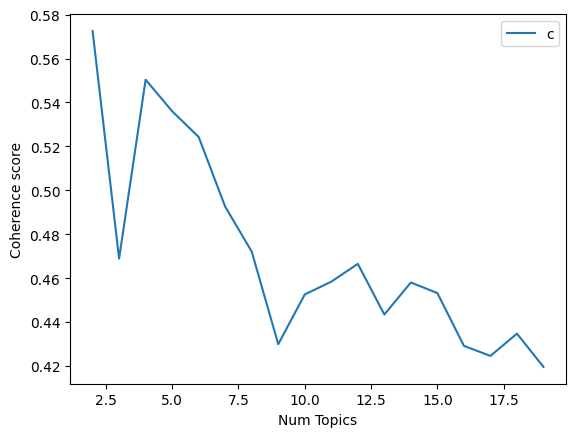

Num Topics = 2  has Coherence Value of 0.5726
Num Topics = 3  has Coherence Value of 0.4689
Num Topics = 4  has Coherence Value of 0.5503
Num Topics = 5  has Coherence Value of 0.536
Num Topics = 6  has Coherence Value of 0.5243
Num Topics = 7  has Coherence Value of 0.4925
Num Topics = 8  has Coherence Value of 0.4721
Num Topics = 9  has Coherence Value of 0.4299
Num Topics = 10  has Coherence Value of 0.4526
Num Topics = 11  has Coherence Value of 0.4584
Num Topics = 12  has Coherence Value of 0.4665
Num Topics = 13  has Coherence Value of 0.4434
Num Topics = 14  has Coherence Value of 0.458
Num Topics = 15  has Coherence Value of 0.4532
Num Topics = 16  has Coherence Value of 0.4292
Num Topics = 17  has Coherence Value of 0.4246
Num Topics = 18  has Coherence Value of 0.4347
Num Topics = 19  has Coherence Value of 0.4196
Topic 0 : Words: ['would', 'god', 'world', 'one', 'good', 'existence', 'human', 'causer', 'gender', 'government']
Topic 1 : Words: ['banned', 'god', 'us', 'sex', 'd

In [ ]:
# Function to compute coherence values for finding optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Creating Dictionary and Corpus
dictionary = Dictionary(top_100_discussions_with_text['Processed_Base_Claim_Text'].apply(word_tokenize))
corpus = [dictionary.doc2bow(text.split()) for text in top_100_discussions_with_text['Processed_Base_Claim_Text']]

# LDA parameters
num_topics = 6
passes = 1000  # Increase passes to 1000


# Defining adjusted seed words for main topics
main_topics_seed_words = {
    'Politics and Society': ['government', 'democracy', 'policy', 'society', 'rights'],
    'Religion and Ethics': ['god', 'faith', 'moral', 'ethical', 'justice'],
    'Science and Technology': ['science', 'research', 'tech', 'internet', 'experiment'],
    'Culture and Lifestyle': ['culture', 'values', 'lifestyle', 'custom', 'tradition']
}

# Initializing the LDA model
lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Modifying the LDA model using seed words
topic_word_distrib = lda_model.get_topics()
for topic_id, seed_words in enumerate(main_topics_seed_words.values()):
    for word in seed_words:
        if word in dictionary.token2id:
            word_id = dictionary.token2id[word]
            topic_word_distrib[topic_id, word_id] *= 10
lda_model.state.get_lambda()[:] = topic_word_distrib
lda_model.sync_state()

# Computing coherence values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=top_100_discussions_with_text['Processed_Base_Claim_Text'].apply(word_tokenize), start=2, limit=20, step=1)

# Plotting
limit = 20; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

# Choosing the model with highest coherence value and printing the topics
optimal_model = model_list[coherence_values.index(max(coherence_values))]
model_topics = optimal_model.show_topics(formatted=False)
for idx, topic in model_topics:
    print(f'Topic {idx} : Words: {[word[0] for word in topic]}')


#### Observations

The LDA model with 4 topics and 1000 passes did not yield satisfactory results. The topics are still not as distinct as we would like them to be. The coherence value suggests 2 topics, but that's too few for our application.

#### Conclusion

Given these outcomes, it seems that LDA, even with guided topic seeding, is not sufficient to create the distinct topic clusters we desire.

#### Next Steps

Exploration of alternative methods is necessary.

## Doc2Vec Model  

In [ ]:
save(top_100_discussions_with_text , f"df_top_100_with_topic_modelling_NumOfTopics_{num_topics}_Passes_{passes}", 3)

df_top_100_with_topic_modelling_NumOfTopics_5_Passes_15.csv saved to /content/drive/MyDrive/Can Language Models Follow Discussions?/3/
File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/3/df_top_100_with_topic_modelling_NumOfTopics_5_Passes_15.csv


TODO: Remove Redundnacies -- identify largest n examples for categories until around 40 discussions are selected as diverse as possible

In [ ]:
tagged_data = [TaggedDocument(words=word_tokenize(preprocess_text_with_stopwords(text, stop_words)), tags=[str(i)]) for i, text in enumerate(node_df['Base_Claim_Text'])]

# Initialize and train Doc2Vec model
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Sample evaluation: Check the most similar discussions for the first 5 discussions
for i in range(5):
    inferred_vector = model.infer_vector(tagged_data[i].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=5)
    print(f"Discussion {i} is most similar to discussions {sims}")

Discussion 0 is most similar to discussions [('16', 0.9708544015884399), ('29', 0.9677069187164307), ('30', 0.9671746492385864), ('40', 0.9635615348815918), ('12', 0.9621424078941345)]
Discussion 1 is most similar to discussions [('73', 0.961760938167572), ('57', 0.9588022828102112), ('113825', 0.9575217366218567), ('187862', 0.9566367268562317), ('147148', 0.9555370211601257)]
Discussion 2 is most similar to discussions [('9489', 0.9719042181968689), ('34', 0.9669861793518066), ('132295', 0.9554800391197205), ('73055', 0.9549001455307007), ('29', 0.9548147916793823)]
Discussion 3 is most similar to discussions [('73823', 0.9696279764175415), ('73789', 0.9681976437568665), ('59', 0.9625146985054016), ('238953', 0.9614571332931519), ('44800', 0.960218071937561)]
Discussion 4 is most similar to discussions [('195800', 0.9501314759254456), ('7', 0.9430612921714783), ('223303', 0.9409130215644836), ('83372', 0.9365952014923096), ('217696', 0.9361051917076111)]


<ipython-input-67-5550fae2a3c1>:11: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  sims = model.docvecs.most_similar([inferred_vector], topn=5)


In [ ]:
# Function to display similar discussions
def display_similar_discussions(i, sims, node_df):
    print(f"Base Claim for Discussion {i}: {node_df.iloc[i]['Base_Claim_Text']}")
    for sim_idx, sim_score in sims:
        sim_idx = int(sim_idx)  # Convert tag back to integer index
        print(f"--> Similar Discussion {sim_idx} (Score: {sim_score}): {node_df.iloc[sim_idx]['Base_Claim_Text']}")

# Sample evaluation: Check the most similar discussions for the first 5 discussions
for i in range(0,10000,1000):
    inferred_vector = model.infer_vector(tagged_data[i].words)
    sims = model.dv.most_similar([inferred_vector], topn=5)  # Updated as per deprecation warning
    print(f"\nDiscussion {i} is most similar to the following discussions:")
    display_similar_discussions(i, sims, node_df)



Discussion 0 is most similar to the following discussions:
Base Claim for Discussion 0: Anonymous currency discussions
--> Similar Discussion 47096 (Score: 0.9552047252655029): The gender binary corresponds to the sex binary.
--> Similar Discussion 187861 (Score: 0.9550874829292297): Moderators should reject all top-level suggestions in mature discussions.
--> Similar Discussion 9489 (Score: 0.9538258910179138): Democracies should not use referendums for policy decisions.
--> Similar Discussion 187862 (Score: 0.9490830302238464): Moderators should reject all top-level suggestions in mature discussions.
--> Similar Discussion 73055 (Score: 0.9477407932281494): Currently, there is no working business-model for journalism.

Discussion 1000 is most similar to the following discussions:
Base Claim for Discussion 1000: The West should build working autonomous killing machines \(AKMs\) as quickly as possible.
--> Similar Discussion 145870 (Score: 0.9753016233444214): World of Warcraft: Class

In [ ]:
import pickle

# Save the model to Google Drive
with open("/content/drive/MyDrive/Can Language Models Follow Discussions?/3/doc2vec_model_v1.pkl", "wb") as f:
    pickle.dump(model, f)


In [ ]:
# Implementing the evaluation function as discussed
def evaluate_model(model, tagged_data, num_discussions=5, topn=5):
    """
    Evaluate a Doc2Vec model by finding the most similar discussions for a given set of discussions.

    Parameters:
    - model: Trained Doc2Vec model
    - tagged_data: List of TaggedDocument objects
    - num_discussions: Number of discussions to evaluate
    - topn: Number of most similar discussions to find

    Returns:
    - similar_discussions: Dictionary containing the most similar discussions for each evaluated discussion
    """
    # Initialize a dictionary to store similar discussions
    similar_discussions = {}

    # Loop through the first 'num_discussions' discussions
    for i in range(min(num_discussions, len(tagged_data))):
        inferred_vector = model.infer_vector(tagged_data[i].words)
        sims = model.dv.most_similar([inferred_vector], topn=topn)

        # Store the most similar discussions
        similar_discussions[i] = sims

    return similar_discussions

# Using the previously trained Doc2Vec model and tagged_data to evaluate
# Note: The model and tagged_data should have been defined in previous steps.
# If not, they would need to be re-defined here.
similar_discussions = evaluate_model(model, tagged_data)
similar_discussions


{0: [('141656', 0.8097482323646545),
  ('214971', 0.8048207759857178),
  ('220100', 0.7932515740394592),
  ('181044', 0.7881550192832947),
  ('157636', 0.7860708832740784)],
 1: [('141656', 0.7759508490562439),
  ('102647', 0.7705294489860535),
  ('170934', 0.7655529975891113),
  ('214971', 0.7653884291648865),
  ('46127', 0.7645848989486694)],
 2: [('214971', 0.7952082753181458),
  ('157636', 0.7908196449279785),
  ('223478', 0.7851925492286682),
  ('158129', 0.7850536108016968),
  ('170934', 0.7746474742889404)],
 3: [('157636', 0.7935214042663574),
  ('220100', 0.7934597730636597),
  ('141656', 0.7796877026557922),
  ('223478', 0.7767208814620972),
  ('214971', 0.7682037353515625)],
 4: [('141656', 0.8127661943435669),
  ('220100', 0.8039183616638184),
  ('157636', 0.8011699318885803),
  ('214971', 0.7920027375221252),
  ('223478', 0.7838546633720398)]}

In [ ]:
from itertools import product
import os

# Save checkpoint function
def save_checkpoint(model, params, base_path_gdrive):
    filename = f"doc2vec_model_vector_{params[0]}_window_{params[1]}_min_count_{params[2]}.model"
    model.save(os.path.join(base_path_gdrive, filename))

# Hyperparameter grid
vector_size = [20, 50, 100]
window = [2, 5, 10]
min_count = [1, 2, 5]

# Cartesian product to get all combinations
param_grid = list(product(vector_size, window, min_count))

# Best parameters variable
best_params = None
best_quality = float('-inf')  # Initialize with negative infinity

# Base path for saving checkpoints
base_path_gdrive_3 = "/content/drive/MyDrive/Can Language Models Follow Discussions?/3"

# Iterate through the hyperparameter grid
for i, params in enumerate(param_grid):
    vec_size, win, min_cnt = params

    print(f"Trying configuration {i+1} out of {len(param_grid)}: vector_size={vec_size}, window={win}, min_count={min_cnt}")

    model = Doc2Vec(vector_size=vec_size, window=win, min_count=min_cnt, workers=4, epochs=100)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

    # Evaluate model
    quality = evaluate_model(model)

    # Log quality
    print(f"Quality for configuration {i+1}: {quality}")

    # Update best parameters if current model is better
    if quality > best_quality:
        best_quality = quality
        best_params = params

    # Save checkpoint
    save_checkpoint(model, params, base_path_gdrive_3)

print(f"Best Parameters: vector_size={best_params[0]}, window={best_params[1]}, min_count={best_params[2]}")


Trying configuration 1 out of 27: vector_size=20, window=2, min_count=1


KeyboardInterrupt: ignored

## Clustering

In [ ]:
list(stop_words)[0]

'his'

In [ ]:
top_100_discussions_with_text['Processed_Base_Claim_Text'] = top_100_discussions_with_text['Base_Claim_Text'].apply(lambda x: preprocess_text_with_stopwords(x, stop_words))

In [ ]:
top_100_discussions_with_text['Processed_Base_Claim_Text'].head(100)

0                                         people follow
1     distinction combined visible fact world entail...
2     distinction combined visible fact world entail...
3         existence evil monotheistic god traditionally
4                                                exists
                            ...                        
95     conservative party choose next uk prime minister
96                           creationism taught schools
97                          feminism empowers women men
98    usage office real estate continue decline past...
99    parents perpetuate myths like santa claus east...
Name: Processed_Base_Claim_Text, Length: 100, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
tfidf_vectorizer = TfidfVectorizer(
    stop_words=list(stop_words),  # Convert set to list
    use_idf=True,
    ngram_range=(1,3)
)

tfidf_matrix = tfidf_vectorizer.fit_transform(top_100_discussions_with_text['Processed_Base_Claim_Text'])

# Rest of the code remains the same

# Standardize the TF-IDF matrix
scaler = StandardScaler()
tfidf_matrix_standardized = scaler.fit_transform(tfidf_matrix.toarray())

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(tfidf_matrix_standardized)

# Add cluster labels to original data
top_100_discussions_with_text['DBSCAN_Cluster'] = dbscan_labels

# Count of discussions in each cluster
cluster_counts = top_100_discussions_with_text['DBSCAN_Cluster'].value_counts()
cluster_counts

-1    100
Name: DBSCAN_Cluster, dtype: int64

In [ ]:
from sklearn.cluster import KMeans

# Number of clusters
n_clusters = 40

# K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_clusters = kmeans.fit_predict(tfidf_matrix)

# Add cluster labels to the DataFrame
top_100_discussions_with_text['KMeans_Cluster'] = kmeans_clusters

# Display the distribution of clusters
cluster_distribution = top_100_discussions_with_text['KMeans_Cluster'].value_counts().sort_index()
cluster_distribution


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0      2
1      3
2      2
3      3
4      4
5      3
6      2
7      5
8      2
9      2
10     1
11     2
12     1
13     1
14     3
15     2
16     3
17     3
18     3
19     3
20     3
21     3
22     2
23     2
24     2
25     1
26     2
27     4
28     2
29     3
30     1
31     3
32     1
33     1
34     4
35     1
36     1
37     1
38    11
39     2
Name: KMeans_Cluster, dtype: int64

In [ ]:
# Get feature names from TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()

# Top features for each cluster
for i, center in enumerate(kmeans.cluster_centers_):
    top_features = [feature_names[j] for j in center.argsort()[-5:]]  # Adjust the number to get more/less features
    print(f"Cluster {i} top features: {top_features}")


Cluster 0 top features: ['churches united', 'churches united states', 'states', 'status', 'united']
Cluster 1 top features: ['involved lives', 'citizens', 'involved lives citizens', 'lives', 'possible']
Cluster 2 top features: ['existence understood', 'understood', 'understood rationality', 'god', 'existence']
Cluster 3 top features: ['meanings often inscribed', 'particular sex', 'gender', 'determined', 'sex']
Cluster 4 top features: ['entails existence aka', 'entails existence', 'entails', 'aka uncaused', 'existence aka']
Cluster 5 top features: ['jinping', 'good china', 'jinping good china', 'xi jinping good', 'china']
Cluster 6 top features: ['referendums policy', 'referendums', 'policy', 'democracies use referendums', 'decisions']
Cluster 7 top features: ['infant', 'infant circumcision banned', 'infant circumcision', 'circumcision', 'banned']
Cluster 8 top features: ['like live world', 'like live', 'live world harry', 'live', 'like']
Cluster 9 top features: ['ethical', 'anarchy eth

In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(tfidf_matrix, kmeans.labels_)
score

0.08830124911372846

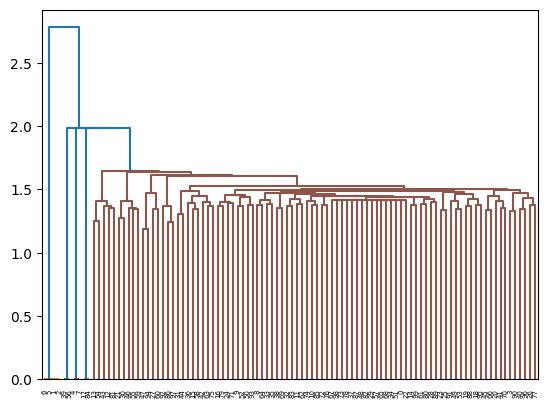

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

# 1. Compute the linkage matrix
Z = linkage(tfidf_matrix.toarray(), 'ward')  # 'ward' is one method to calculate distance

# 2. Plot the dendrogram to visualize the cluster tree
dendrogram(Z)
plt.show()

# 3. Choose a distance threshold and extract clusters
max_d = 3  # You can decide this value by examining the dendrogram
clusters = fcluster(Z, max_d, criterion='distance')

# 4. Assign clusters back to your data
top_100_discussions_with_text['Hierarchical_Cluster'] = clusters


In [ ]:
grouped = top_100_discussions_with_text.groupby('Hierarchical_Cluster')
for name, group in grouped:
    print("Group Size:", grouped.size())
    print(f"Cluster {name}:")
    print(group['Base_Claim_Text'])
    print()


Group Size: Hierarchical_Cluster
1    100
dtype: int64
Cluster 1:
0     What [religion](https://en.wikipedia.org/wiki/...
1     The distinction between [Act and Potency](http...
2     The distinction between [Act and Potency](http...
3     Because of the existence of evil, there cannot...
4     [God](https://en.wikipedia.org/wiki/Classical_...
                            ...                        
95    Who should the Conservative Party choose to be...
96             Creationism should be taught in schools.
97                Feminism empowers both women and men.
98    The usage of office real estate will continue ...
99    Parents should not perpetuate myths like Santa...
Name: Base_Claim_Text, Length: 100, dtype: object



In [ ]:
grouped.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Base_Claim_ID,Number_of_Claims,Base_Claim_Text,Shortened_Base_Claim_Text,Processed_Base_Claim_Text,DBSCAN_Cluster,KMeans_Cluster,Hierarchical_Cluster
0,3371.0,1298,What [religion](https://en.wikipedia.org/wiki/...,What [religion](https://en.wikipedia.org/wiki/...,people follow,-1,20,1
1,53584.1,1263,The distinction between [Act and Potency](http...,The distinction between [Act and Potency](http...,distinction combined visible fact world entail...,-1,4,1
2,51234.1,1091,The distinction between [Act and Potency](http...,The distinction between [Act and Potency](http...,distinction combined visible fact world entail...,-1,4,1
3,29870.1,1091,"Because of the existence of evil, there cannot...","Because of the existence of evil, there cannot...",existence evil monotheistic god traditionally,-1,2,1
4,2629.1,1005,[God](https://en.wikipedia.org/wiki/Classical_...,[God](https://en.wikipedia.org/wiki/Classical_...,exists,-1,17,1


In [ ]:
save(grouped,"cluster data _frame dbscan_kmeans_hierarchical", 3, "csv")

File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/3/cluster data _frame dbscan_kmeans_hierarchical.csv


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## LDA 2



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    stop_words=list(stop_words),  # Convert set to list
    use_idf=True,
    ngram_range=(1, 3)
)

# Fit and transform the processed titles
tfidf_matrix = tfidf_vectorizer.fit_transform(top_100_discussions_with_text['Processed_Base_Claim_Text'])

# Define Search Params
search_params = {'n_components': [10, 20, 30, 40], 'learning_decay': [.5, .7, .9]}

# Init the LDA Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
grid_search_model = GridSearchCV(lda, param_grid=search_params)

# Perform Grid Search
grid_search_model.fit(tfidf_matrix)

# Extract Best LDA Model
best_lda_model = grid_search_model.best_estimator_

# Fit the best model
best_lda_model.fit(tfidf_matrix)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation()

In [ ]:
lda_model.top_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method LdaModel.top_topics of <gensim.models.ldamodel.LdaModel object at 0x7c7d761dca90>>

In [ ]:
save(best_lda_model,"best_lda_model_v1",3,output_type = "pk")

File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/3/best_lda_model_v1.pk


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pyLDAvis
from gensim.models import LdaModel

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_lda_model, tfidf_matrix, tfidf_vectorizer)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: ignored

In [ ]:
#!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_lda_model, tfidf_matrix, tfidf_vectorizer)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: ignored

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(best_lda_model, tfidf_matrix, tfidf_vectorizer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: ignored

In [ ]:
import pprint
pprint(best_lda_model.top_topics())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: ignored

In [ ]:

print("Best LDA model's params" , best_lda_model.get_params())

print("LDA model Perplexity on train data", best_lda_model.perplexity(tfidf_matrix))
print("Components:", best_lda_model.components_)
print("Score:", best_lda_model.score(tfidf_matrix))

print("top 5 words for each topics")
print(lda_model.print_topics(num_words=5))  # print top 5 words for each topics

print("top identified topics")
print(lda_model.top_topics(corpus))



Best LDA model's params {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
LDA model Perplexity on train data 51864.00226475856
Components: [[0.1        0.1        0.1        ... 0.44502233 0.44502233 0.44502233]
 [0.1        0.1        0.1        ... 0.1        0.1        0.1       ]
 [0.39558594 0.39558594 0.39558594 ... 0.1        0.1        0.1       ]
 ...
 [0.1        0.1        0.1        ... 0.1        0.1        0.1       ]
 [0.1        0.1        0.1        ... 0.1        0.1        0.1       ]
 [0.1        0.1        0.1        ... 0.1        0.1        0.1       ]]
Score: -4041.1360182837307
top 5 words for each topics


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

In [ ]:

def visualize_lda_with_tsne(lda_model, tfidf_matrix, tfidf_vectorizer):
  """Visualizes the results of an LDA model using t-SNE.

  Args:
    lda_model: A fitted LDA model.
    tfidf_matrix: A TF-IDF matrix of the data.
    tfidf_vectorizer: A fitted TF-IDF vectorizer.

  Returns:
    A matplotlib figure object.
  """

  # Create a t-SNE embedding of the topics.
  tsne_model = TSNE(n_components=2)
  tsne_embedding = tsne_model.fit_transform(lda_model.components_)

  # Plot the topics.
  fig, ax = plt.subplots(figsize=(10, 10))
  ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=lda_model.components_[:, 0])
  ax.set_xlabel('Topic 1')
  ax.set_ylabel('Topic 2')
  ax.set_title('LDA Topic Visualization')

  return fig
# Visualize the results of the LDA model using t-SNE.
fig = visualize_lda_with_tsne(best_lda_model, tfidf_matrix, tfidf_vectorizer)

# Display the visualization.
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation

# Create a t-SNE embedding of the topics
tsne_model = TSNE(n_components=2, perplexity=50)
tsne_embedding = tsne_model.fit_transform(best_lda_model.components_)

# Plot the topics
plt.figure(figsize=(10, 10))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=best_lda_model.components_[:, 0])
plt.xlabel('Topic 1')
plt.ylabel('Topic 2')
plt.title('LDA Topic Visualization')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: ignored

In [ ]:
# LDA model
top_lda=lda.fit_transform(document_term_matrix)

print(top_lda.shape)
print(top_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

In [ ]:
!pip install ldaviz

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ERROR: Could not find a version that satisfies the requirement ldaviz (from versions: none)
ERROR: No matching distribution found for ldaviz


In [ ]:
import ldaViz

# Create an LDAViz object
lda_viz = ldaViz.LDAvis(best_lda_model, tfidf_matrix, tfidf_vectorizer)

# Display the visualization
lda_viz.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: ignored

In [ ]:
import pyLDAvis

pyLDAvis.enable_notebook()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pyLDAvis.prepare(mds='tsne', **tfidf_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: ignored

In [ ]:
# composition of doc 0 for eg
print("Document 0: ")
for i,topic in enumerate(top_lda[0]):
  print("Topic ",i,": ",topic*100,"%")

In [ ]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def word_cloud_lda(index):
  imp_words_topic=""
  comp=lda.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400,max_font_size=100).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for word_cloud in word_cloud_lda:
  print(word_cloud)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: ignored

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: ignored

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(best_lda_model, tfidf_vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
best times humans vegan vegan lockdown wrong lockdown wrong times humans best taught schools
Topic 1:
capitalism good capitalism good people follow follow polygamy polygamy legal legal alternative people
Topic 2:
use superior men women superior men women superior men superior women abortion objection conscientious objection abortion
Topic 3:
obama like life switch voting voting system us system us system us switch us switch voting system
Topic 4:
defunded police police defunded force force good un force good un force un armed teachers armed guns
Topic 5:
exists existence aka aka combined visible entails existence entails fact aka uncaused causer fact world fact world entails
Topic 6:
would democracy public system society ethical system ethical ethical system society anarchy anarchy ethical anarchy ethical system
Topic 7:
determined banned sex gender american american football american football banned football banned football mars
Topic 8:
society gender gender would better gen

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 1.) restart runtime
!pip uninstall pandas numpy numba pyLDAvis


Found existing installation: pandas 2.1.1
Uninstalling pandas-2.1.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/pandas-2.1.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/pandas/*
Proceed (Y/n)? Y
  Successfully uninstalled pandas-2.1.1
Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.24.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-15028c96.3.21.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.24.3
Found existing installation: numba 0.56.4
Uninstalling numba-0.56.4:
  Would remove:
    /usr/local/bin/numba
    /usr/local/bin/pycc
 

In [ ]:
import sys
print("Python version")
print (sys.version)

print("Version info.")
print (sys.version_info)

Python version
3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Version info.
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [ ]:
!pip install pyldavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 31.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [ ]:
!pip install funcy
!pip install tzdata
!pip install numpy==1.23.5
!pip install pandas==1.5.3
!pip install pyldavis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 47.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.1
    Uninstalling numpy-1.26.1:
      Successfully uninstalled numpy-1.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pyldavis 3.4.1 requires numpy>=1.24.2, but you have numpy 1.23.5 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 17.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.1
    Uninstalling pandas-2.1.1:
      Successfully uninstalled pandas-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pyldavis 3.4.1 requires numpy>=1.24.2, but you have numpy 1.23.5 which is incompatible.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
  Using cached numpy-1.26.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached pandas-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 M

In [ ]:
!pip install graphlab

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ERROR: Could not find a version that satisfies the requirement graphlab (from versions: none)
ERROR: No matching distribution found for graphlab


In [ ]:
!pip install graphlab


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ERROR: Could not find a version that satisfies the requirement graphlab (from versions: none)
ERROR: No matching distribution found for graphlab


In [ ]:
from __future__ import division

import graphlab as gl

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: ignored

In [ ]:
!pip install pyLDAvis==3.4.1

In [ ]:
!pip install pandas==1.5.3

In [ ]:
!pip install pandas==1.2.5 numpy==1.21.2 numba==0.52.0 pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 16.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 66.3 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 0.52.0 Requires-Python >=3.6,<3.9; 0.52.0rc3 Requires-Python >=3.6,<3.9; 0.53.0 Requires-Python >=3.6,<3.10; 0.53.0rc1.post1 Requires-Python >=3.6,<3.10; 0.53.0rc2 Requires-Python >=3.6,<3.10; 0.53.0rc3 Requires-Python >=3.6,<3.10; 0.53.1 Requires-Python >=3.6,<3.10; 0.54.0 Requires-Python >=3.7,<3.10; 0.54.0rc2 Requires-Python >=3.7,<3.10; 0.54.0rc3 Requires-Python >=3.7,<3.10; 0.54.1 Requires-Python >=3.7,<3.10
ERROR: Could not find a version that satisfies the requirement numba==0.52.0 (from versions: 0.1, 0.2, 0.3, 0.5.0, 0.6.0, 0.7.0, 0.7.1, 0.7.2, 0.8.0, 0.8.1, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.12.

In [ ]:
!pip install numba==0.53.0 pyLDAvis

ERROR: Ignored the following versions that require a different python version: 0.52.0 Requires-Python >=3.6,<3.9; 0.52.0rc3 Requires-Python >=3.6,<3.9; 0.53.0 Requires-Python >=3.6,<3.10; 0.53.0rc1.post1 Requires-Python >=3.6,<3.10; 0.53.0rc2 Requires-Python >=3.6,<3.10; 0.53.0rc3 Requires-Python >=3.6,<3.10; 0.53.1 Requires-Python >=3.6,<3.10; 0.54.0 Requires-Python >=3.7,<3.10; 0.54.0rc2 Requires-Python >=3.7,<3.10; 0.54.0rc3 Requires-Python >=3.7,<3.10; 0.54.1 Requires-Python >=3.7,<3.10
ERROR: Could not find a version that satisfies the requirement numba==0.53.0 (from versions: 0.1, 0.2, 0.3, 0.5.0, 0.6.0, 0.7.0, 0.7.1, 0.7.2, 0.8.0, 0.8.1, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.12.2, 0.13.0, 0.13.2, 0.13.3, 0.13.4, 0.14.0, 0.15.1, 0.16.0, 0.17.0, 0.18.1, 0.18.2, 0.19.1, 0.19.2, 0.20.0, 0.21.0, 0.22.0, 0.22.1, 0.23.0, 0.23.1, 0.24.0, 0.25.0, 0.26.0, 0.27.0, 0.28.1, 0.29.0, 0.30.0, 0.30.1, 0.31.0, 0.32.0, 0.33.0, 0.34.0, 0.35.0, 0.36.1, 0.36.2, 0.37.0, 0.38.0, 0.38.1, 0.39

In [ ]:
!pip install pandas==1.5.3 numpy==1.21.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.1
    Uninstalling numpy-1.26.1:
      Successfully uninstalled numpy-1.26.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.1
    Uninstalling pandas-2.1.1:
      Successfully uninstalled pandas-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
!pip show pandas numpy numba pyLDAvis


In [ ]:
!pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached pandas-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.


# New Section